### 1. Importar les llibreries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import pickle
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss, roc_curve

****
### 2. Carregar el dataset

In [51]:
df = pd.read_csv('https://raw.githubusercontent.com/Nicolakorff/Projecte-Machine-Learning/refs/heads/main/datasets/bank_dataset_wins.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59.0,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1033,1,-1.0,0.0,unknown,yes
1,56.0,admin.,married,secondary,no,45,no,no,unknown,5,may,1033,1,-1.0,0.0,unknown,yes
2,41.0,technician,married,secondary,no,1270,yes,no,unknown,5,may,1033,1,-1.0,0.0,unknown,yes
3,55.0,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1.0,0.0,unknown,yes
4,54.0,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1.0,0.0,unknown,yes


In [52]:
# Columnes importants per al model: 'age', 'balance', 'loan', 'campaign', 'job', 'education', 'housing', 'month' i 'marital'.

df.drop("pdays", axis=1, inplace=True)
df.drop("default", axis=1, inplace=True)
df.drop("duration", axis=1, inplace=True)
df.drop("contact", axis=1, inplace=True)
df.drop("previous", axis=1, inplace=True)
df.drop("poutcome", axis=1, inplace=True)
df.drop("day", axis=1, inplace=True)

df.to_csv('bank_dataset_cut.csv', index=False)

In [53]:
# transformar 'age' de float a integrer
df['age'] = df['age'].astype(int)

In [54]:
df.head()

,age,job,marital,education,balance,housing,loan,month,campaign,deposit
0,59,admin.,married,secondary,2343,yes,no,may,1,yes
1,56,admin.,married,secondary,45,no,no,may,1,yes
2,41,technician,married,secondary,1270,yes,no,may,1,yes
3,55,services,married,secondary,2476,yes,no,may,1,yes
4,54,admin.,married,tertiary,184,no,no,may,2,yes


In [55]:
# comprovar el balanç de classes de la variable de resultat
print(df['deposit'].value_counts(normalize=True) * 100)

deposit
no     52.616019
yes    47.383981
Name: proportion, dtype: float64


****
### 3. Divisió del dataset

In [56]:
# Després de comprovar el balanç de les classes es divideix el dataset en conjunts d'entrenament i prova en un 80/20.
# S'ha considerat el 80/20 el més adient per la quatitat de dades, el balaç de les classes i tipus diferent de dades.

# Definició de característicques (X) y variable de resultat (y).
X = df.drop(columns='deposit')  # Característiques
y = df['deposit']  # Variable de resultat

# Divisió en entrenamient (80%) y proba (20%) amb estratificació
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)

# Verificar que la proporció de classes es mante en els dos conjunts
print("Grandària del conjunt d'entrenament (train):")
print(y_train.value_counts(normalize=True))
print("Grandària del conjunt de prova (test):")
print(y_test.value_counts(normalize=True))

Grandària del conjunt d'entrenament (train):
deposit
no     0.526151
yes    0.473849
Name: proportion, dtype: float64
Grandària del conjunt de prova (test):
deposit
no     0.526198
yes    0.473802
Name: proportion, dtype: float64


In [57]:
# Desar els conjunts en fitxers CSV
X_train.to_csv('bank_dataset_X_train.csv', index=False)
X_test.to_csv('bank_dataset_X_test.csv', index=False)
y_train.to_csv('bank_dataset_y_train.csv', index=False)
y_test.to_csv('bank_dataset_y_test.csv', index=False)

# Per facilitar el codi anomenem X_train = train ; X_test = test

train = X_train
test = X_test

# Comprovar les primeres files dels conjunts
train.head()

,age,job,marital,education,balance,housing,loan,month,campaign
4868,26,technician,single,secondary,181,no,no,apr,2
486,26,services,single,secondary,-189,no,yes,jul,2
2466,59,retired,divorced,tertiary,3444,no,no,aug,1
5952,43,housemaid,married,primary,0,yes,no,aug,3
1721,25,student,single,secondary,1608,no,no,apr,2


In [58]:
test.head()

,age,job,marital,education,balance,housing,loan,month,campaign
8771,25,admin.,single,secondary,483,no,yes,apr,1
2823,76,retired,married,secondary,4087,no,no,oct,2
9911,28,services,married,secondary,4,yes,no,jun,5
5111,27,admin.,married,secondary,1595,no,no,dec,2
5682,36,management,single,tertiary,13,no,yes,nov,1


- S' ajusta els conjunts train i test en transformació/codificació de variables.
- Inicialment s'aplica l'escalador unicament al conjunt de train i s´aplicar posteriorment sense ajustar al conjunt de test.

****
### 4. Transformar variables categóriques

In [59]:
train2 = train.copy()
test2 = test.copy()
# Veure els valors únics a la columna 'education'
unique_education_train = train2['education'].unique()
print(unique_education_train)

['secondary' 'tertiary' 'primary' 'unknown']


In [60]:
# Us del mappeig manual, per endreçar ordinalment escullint l'enumaració
# Especificar l'ordre amb el diccionari
education_map = {'secondary': 2, 'tertiary': 3, 'primary': 1, 'unknown': 0}

# Aplicar el mappeig a la columna
train2['education_encoded'] = train2['education'].map(education_map)
test2['education_encoded'] = test2['education'].map(education_map)

# Verificar les etiquetes amb els sus codis
print(train2[['education', 'education_encoded']].drop_duplicates())
print(test2[['education', 'education_encoded']].drop_duplicates())

      education  education_encoded
4868  secondary                  2
2466   tertiary                  3
5952    primary                  1
5250    unknown                  0
       education  education_encoded
8771   secondary                  2
5682    tertiary                  3
11097    primary                  1
3784     unknown                  0


In [61]:
# Eliminar columnes originals:
train2.drop("education", axis=1, inplace=True)
test2.drop("education", axis=1, inplace=True)

In [62]:
# Label Encoding per 'education', 'month', 'poutcome' al ser valors ordinaris 
# Veure els valors únics a la columna 'month'
unique_month_train = train2['month'].unique()
print(unique_month_train)

['apr' 'jul' 'aug' 'nov' 'jun' 'jan' 'may' 'oct' 'feb' 'dec' 'sep' 'mar']


In [63]:
# Us de OrdinalEncoder 
encoder = OrdinalEncoder()
# Ordre específic
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
# Configurar l'OrdinalEncoder amb l'ordre desitjat
ordinal_encoder = OrdinalEncoder(categories=[month_order])
# Ajustar i transformar la columna
train2['month_encoded'] = ordinal_encoder.fit_transform(train[['month']])
test2['month_encoded'] = ordinal_encoder.fit_transform(test[['month']])

In [64]:
train2['month_encoded'] = train2['month_encoded'].astype(int)
test2['month_encoded'] = test2['month_encoded'].astype(int)

In [65]:
# Verificar les etiquetes amb els sus codis
print(train2[['month', 'month_encoded']].drop_duplicates())   
print(test2[['month', 'month_encoded']].drop_duplicates())

      month  month_encoded
4868    apr              3
486     jul              6
2466    aug              7
8789    nov             10
10804   jun              5
11010   jan              0
8481    may              4
7949    oct              9
4759    feb              1
3003    dec             11
3982    sep              8
1348    mar              2
      month  month_encoded
8771    apr              3
2823    oct              9
9911    jun              5
5111    dec             11
5682    nov             10
7405    jul              6
11011   may              4
1200    feb              1
7776    aug              7
4480    mar              2
8745    jan              0
10742   sep              8


In [66]:
# Eliminar columnes job_grouped:
train2.drop("month", axis=1, inplace=True)
test2.drop("month", axis=1, inplace=True)

In [67]:
# Transformació de la variable 'job' fent una agrupació de les categories per reduir dimensionalitat
unique_job = train2['job'].unique()
print(unique_job)

['technician' 'services' 'retired' 'housemaid' 'student' 'management'
 'unemployed' 'admin.' 'self-employed' 'entrepreneur' 'blue-collar'
 'unknown']


In [68]:
# Agrupació de la variable 'job'
# Mappeig
job_groups = {
    'admin.': 'qualified',
    'blue-collar': 'qualified',
    'technician': 'qualified',
    'management': 'qualified',
    'services': 'semi-qualified',
    'entrepreneur': 'freelance',
    'self-employed': 'freelance',
    'student': 'no qualified',
    'retired': 'qualified',
    'unemployed': 'no qualified',
    'housemaid': 'semi-qualified',
    'unknown': 'other'
}

In [69]:
# Aplicar el mappeig per agrupar categories
train2['job_grouped'] = train2['job'].map(job_groups)
test2['job_grouped'] = test2['job'].map(job_groups)

# Verificar la nova columna
print(train2[['job', 'job_grouped']].drop_duplicates()) 
print(test2[['job', 'job_grouped']].drop_duplicates()) 

                job     job_grouped
4868     technician       qualified
486        services  semi-qualified
2466        retired       qualified
5952      housemaid  semi-qualified
1721        student    no qualified
8789     management       qualified
3819     unemployed    no qualified
7949         admin.       qualified
4962  self-employed       freelance
4870   entrepreneur       freelance
9634    blue-collar       qualified
3253        unknown           other
                job     job_grouped
8771         admin.       qualified
2823        retired       qualified
9911       services  semi-qualified
5682     management       qualified
7405  self-employed       freelance
3772     technician       qualified
2609     unemployed    no qualified
5243    blue-collar       qualified
3511        unknown           other
2069      housemaid  semi-qualified
3326        student    no qualified
9393   entrepreneur       freelance


In [70]:
# Convertir a valors numérics
job_group_mapping = {'semi-qualified': 3, 'qualified': 2, 'retired': 0, 'other': 5, 'no qualified': 4, 'freelance': 1}
train2['job_grouped_encoded'] = train2['job_grouped'].map(job_group_mapping)
test2['job_grouped_encoded'] = test2['job_grouped'].map(job_group_mapping)

# Verificar els valors codificats
print(train2[['job_grouped', 'job_grouped_encoded']].drop_duplicates())
print(test2[['job_grouped', 'job_grouped_encoded']].drop_duplicates())

         job_grouped  job_grouped_encoded
4868       qualified                    2
486   semi-qualified                    3
1721    no qualified                    4
4962       freelance                    1
3253           other                    5
         job_grouped  job_grouped_encoded
8771       qualified                    2
9911  semi-qualified                    3
7405       freelance                    1
2609    no qualified                    4
3511           other                    5


In [71]:
# Eliminar columnes originals:
train2.drop("job", axis=1, inplace=True)
test2.drop("job", axis=1, inplace=True)

# Verificació:
train2.head()

,age,marital,balance,housing,loan,campaign,education_encoded,month_encoded,job_grouped,job_grouped_encoded
4868,26,single,181,no,no,2,2,3,qualified,2
486,26,single,-189,no,yes,2,2,6,semi-qualified,3
2466,59,divorced,3444,no,no,1,3,7,qualified,2
5952,43,married,0,yes,no,3,1,7,semi-qualified,3
1721,25,single,1608,no,no,2,2,3,no qualified,4


In [72]:
test2.head()

,age,marital,balance,housing,loan,campaign,education_encoded,month_encoded,job_grouped,job_grouped_encoded
8771,25,single,483,no,yes,1,2,3,qualified,2
2823,76,married,4087,no,no,2,2,9,qualified,2
9911,28,married,4,yes,no,5,2,5,semi-qualified,3
5111,27,married,1595,no,no,2,2,11,qualified,2
5682,36,single,13,no,yes,1,3,10,qualified,2


In [73]:
# Eliminar columnes job_grouped:
train2.drop("job_grouped", axis=1, inplace=True)
test2.drop("job_grouped", axis=1, inplace=True)

In [74]:
# One-Hot Encoding per 'loan', 'housing', 'deafult', 'marital', 'contact', ja que no es poden ordenar de foma ordinal
train3 = train2
test3 = test2

In [75]:
# Utilitzar get_dummies per a 'loan', 'housing', 'deafult', al ser columnes amb valors binaris
train3 = pd.get_dummies(train3, columns=['loan'], prefix='loan')
train3 = pd.get_dummies(train3, columns=['housing'], prefix='housing')
test3 = pd.get_dummies(test3, columns=['loan'], prefix='loan')
test3 = pd.get_dummies(test3, columns=['housing'], prefix='housing')

In [76]:
# Verificar les etiquetes amb els sus codis
print(train3[['loan_yes', 'loan_no']].drop_duplicates())
print(test3[['loan_yes', 'loan_no']].drop_duplicates())
print(train3[['housing_yes', 'housing_no']].drop_duplicates())
print(test3[['housing_yes', 'housing_no']].drop_duplicates())

      loan_yes  loan_no
4868     False     True
486       True    False
      loan_yes  loan_no
8771      True    False
2823     False     True
      housing_yes  housing_no
4868        False        True
5952         True       False
      housing_yes  housing_no
8771        False        True
9911         True       False


In [77]:
train3['loan'] = train3['loan_yes'].astype(int)
train3.drop(['loan_yes', 'loan_no'], axis=1, inplace=True)
test3['loan'] = test3['loan_yes'].astype(int)
test3.drop(['loan_yes', 'loan_no'], axis=1, inplace=True)
train3['housing'] = train3['housing_yes'].astype(int)
train3.drop(['housing_yes', 'housing_no'], axis=1, inplace=True)
test3['housing'] = test3['housing_yes'].astype(int)
test3.drop(['housing_yes', 'housing_no'], axis=1, inplace=True)

In [78]:
# Verificació
train3.head()

,age,marital,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing
4868,26,single,181,2,2,3,2,0,0
486,26,single,-189,2,2,6,3,1,0
2466,59,divorced,3444,1,3,7,2,0,0
5952,43,married,0,3,1,7,3,0,1
1721,25,single,1608,2,2,3,4,0,0


In [79]:
test3.head()

,age,marital,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing
8771,25,single,483,1,2,3,2,1,0
2823,76,married,4087,2,2,9,2,0,0
9911,28,married,4,5,2,5,3,0,1
5111,27,married,1595,2,2,11,2,0,0
5682,36,single,13,1,3,10,2,1,0


In [80]:
# Utilitzar get_dummies per a la variable de resultat'deposit', també de valors binaris
y_train = pd.get_dummies(y_train, columns=['deposit'], prefix='deposit')
y_test = pd.get_dummies(y_test, columns=['deposit'], prefix='deposit')
# Verificar les etiquetes amb els sus codis
print(y_train[['deposit_yes', 'deposit_no']].drop_duplicates())
print(y_test[['deposit_yes', 'deposit_no']].drop_duplicates())

      deposit_yes  deposit_no
4868         True       False
5952        False        True
      deposit_yes  deposit_no
8771        False        True
2823         True       False


In [81]:
y_train['deposit'] = y_train['deposit_yes'].astype(int)
y_train.drop(['deposit_yes', 'deposit_no'], axis=1, inplace=True)
y_test['deposit'] = y_test['deposit_yes'].astype(int)
y_test.drop(['deposit_yes', 'deposit_no'], axis=1, inplace=True)

In [82]:
train4=train3
test4=test3

In [83]:
# Crear i ajustar el OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train4[['marital']])

# Codificar
marital_encoded_train = encoder.transform(train4[['marital']])
marital_encoded_test = encoder.transform(test4[['marital']])

# Crear un DataFrame per a la codificació de 'marital'
marital_encoded_train_df = pd.DataFrame(marital_encoded_train, columns=encoder.get_feature_names_out(['marital']))
marital_encoded_test_df = pd.DataFrame(marital_encoded_test, columns=encoder.get_feature_names_out(['marital']))

# Resetejar els índexs per assegurar alineació
train4 = train4.reset_index(drop=True)
marital_encoded_train_df = marital_encoded_train_df.reset_index(drop=True)
test4 = test4.reset_index(drop=True)
marital_encoded_test_df = marital_encoded_test_df.reset_index(drop=True)

# Concatenar els DataFrames amb l'eix correcte (axis=1) per afegir les columnes codificades
train4 = pd.concat([train4, marital_encoded_train_df], axis=1)
test4 = pd.concat([test4, marital_encoded_test_df], axis=1)

# Verificar les columnes generades
print("Noves columnes codificades:", encoder.get_feature_names_out(['marital']))
print("Dimensions despres de concatenar:")
print("train4:", train4.shape)
print("test4:", test4.shape)

Noves columnes codificades: ['marital_divorced' 'marital_married' 'marital_single' 'marital_unknown']
Dimensions despres de concatenar:
train4: (8929, 13)
test4: (2233, 13)


In [84]:
# Eliminar columnes originals:
train4.drop("marital", axis=1, inplace=True)
test4.drop("marital", axis=1, inplace=True)

In [85]:
# Verificar:
train4.head()

,age,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
0,26,181,2,2,3,2,0,0,0.0,0.0,1.0,0.0
1,26,-189,2,2,6,3,1,0,0.0,0.0,1.0,0.0
2,59,3444,1,3,7,2,0,0,1.0,0.0,0.0,0.0
3,43,0,3,1,7,3,0,1,0.0,1.0,0.0,0.0
4,25,1608,2,2,3,4,0,0,0.0,0.0,1.0,0.0


In [86]:
test4.head()

,age,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
0,25,483,1,2,3,2,1,0,0.0,0.0,1.0,0.0
1,76,4087,2,2,9,2,0,0,0.0,1.0,0.0,0.0
2,28,4,5,2,5,3,0,1,0.0,1.0,0.0,0.0
3,27,1595,2,2,11,2,0,0,0.0,1.0,0.0,0.0
4,36,13,1,3,10,2,1,0,0.0,0.0,1.0,0.0


In [87]:
# Desar el DataFrame estandarditzat en un fitxer CSV
train4.to_csv('bank_dataset_X_train_stand.csv', index=False)
test4.to_csv('bank_dataset_X_test_stand.csv', index=False)
y_train.to_csv('bank_dataset_y_train_stand.csv', index=False)
y_test.to_csv('bank_dataset_y_test_stand.csv', index=False)

****
### 5. Estandarització o Normalització de les dades

**5.1 Tractactament d'outliers al conjunt train**

In [88]:
train5 = pd.read_csv('bank_dataset_X_train_stand.csv')
test5 = pd.read_csv('bank_dataset_X_test_stand.csv')

In [89]:
train5.head()

,age,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
0,26,181,2,2,3,2,0,0,0.0,0.0,1.0,0.0
1,26,-189,2,2,6,3,1,0,0.0,0.0,1.0,0.0
2,59,3444,1,3,7,2,0,0,1.0,0.0,0.0,0.0
3,43,0,3,1,7,3,0,1,0.0,1.0,0.0,0.0
4,25,1608,2,2,3,4,0,0,0.0,0.0,1.0,0.0


In [90]:
## Detecció d'outliers
# Llistar columnes a detectar outliers
columns_to_check = ['balance', 'campaign',]

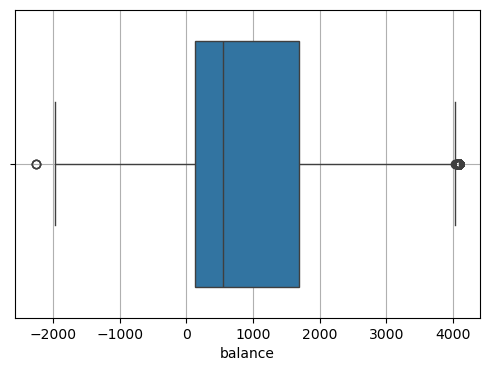

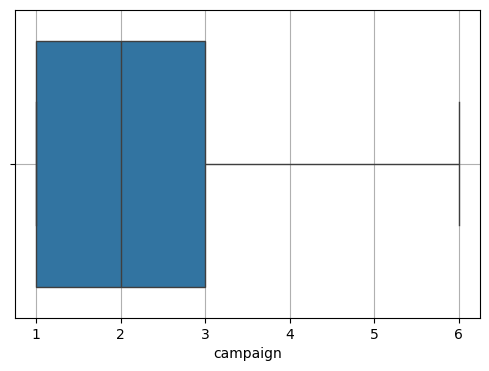

In [91]:
# Crear diagrames de caixa per visualitzar outliers a cada columna
for column in columns_to_check:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train4[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # S'han detectat outliers a 'age' i 'balance'.

In [92]:
# Tractar outliers aplicant la técnica de Winsorització per mantenir l'estructura del dataset
# Funció per calcular límits IQR
def calculate_iqr_limits(train5, columns):
    limits_dict = {}
    
    for column in columns:
        Q1 = train5[column].quantile(0.25)
        Q3 = train5[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        limits_dict[column] = (lower_bound, upper_bound)
        
    return limits_dict

In [93]:
# Funció per winsoritzar dades
def winsorize_data(train5, columns):
    limits_dict = calculate_iqr_limits(train5, columns)
    
    for column, (lower_bound, upper_bound) in limits_dict.items():
        # Winsoritzar: Reemplaçar valors menors al límit inferior i majores al límit superior
        train5[column] = np.clip(train5[column], lower_bound, upper_bound)
        
    return train5

In [94]:
# Definir les columnas a winsoritzar
columns_to_check = ['balance']

# Aplicar winsorització a les columnes especificades
train_winsorized = winsorize_data(train5, columns_to_check)
test_winsorized = winsorize_data(test5, columns_to_check)

# Guardar el DataFrame en un archiu CSV
train_winsorized.to_csv('bank_dataset_X_train_stand.csv', index=False)
test_winsorized.to_csv('bank_dataset_X_test_stand.csv', index=False)

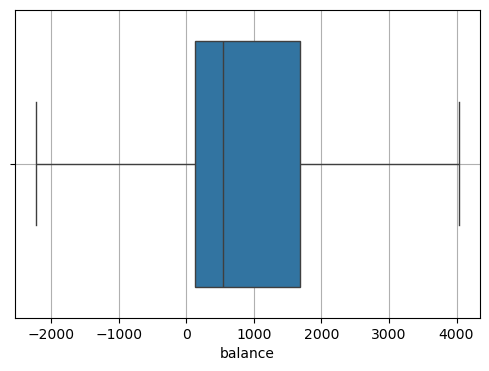

In [95]:
# Comprobar que no hi hagi outliers
for column in columns_to_check:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train_winsorized[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # No es detecten outliers

In [96]:
train_winsorized.head()

,age,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
0,26,181,2,2,3,2,0,0,0.0,0.0,1.0,0.0
1,26,-189,2,2,6,3,1,0,0.0,0.0,1.0,0.0
2,59,3444,1,3,7,2,0,0,1.0,0.0,0.0,0.0
3,43,0,3,1,7,3,0,1,0.0,1.0,0.0,0.0
4,25,1608,2,2,3,4,0,0,0.0,0.0,1.0,0.0


In [97]:
# Obtenir una descripció estadística del DataFrame `train4`
train_winsorized.describe()

,age,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
count,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000
mean,41.270691,1102.708254,2.236085,2.106171,5.191287,2.192631,0.130810,0.475193,0.114459,0.569493,0.315601,0.000448
std,11.925699,1334.265759,1.523646,0.797436,2.572412,0.676397,0.337211,0.499412,0.318385,0.495175,0.464781,0.021162
min,18.000000,-2224.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,122.000000,1.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,546.000000,2.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,49.000000,1686.000000,3.000000,3.000000,7.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,95.000000,4032.000000,6.000000,3.000000,11.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
# Mostrar les primeres 5 filas del DataFrame `test4`
test_winsorized.head()

,age,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
0,25,483,1,2,3,2,1,0,0.0,0.0,1.0,0.0
1,76,4087,2,2,9,2,0,0,0.0,1.0,0.0,0.0
2,28,4,5,2,5,3,0,1,0.0,1.0,0.0,0.0
3,27,1595,2,2,11,2,0,0,0.0,1.0,0.0,0.0
4,36,13,1,3,10,2,1,0,0.0,0.0,1.0,0.0


In [99]:
# Obtenir una descripció estadística del DataFrame `test4`
test_winsorized.describe()

,age,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000
mean,41.093148,1155.190327,2.248545,2.103448,5.188983,2.173757,0.130766,0.464845,0.120466,0.566055,0.313032,0.000448
std,11.846589,1364.910971,1.511464,0.790599,2.574886,0.650538,0.337220,0.498874,0.325578,0.495729,0.463831,0.021162
min,18.000000,-2257.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,126.000000,1.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,560.000000,2.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,49.000000,1794.000000,3.000000,3.000000,7.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,87.000000,4087.000000,6.000000,3.000000,11.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


****
**5.3 Estandarització de variables numériques del conjunt train i test**

In [100]:
# Crear una copia para no afectar los datos originales
train6 = train_winsorized.copy()
test6 = test_winsorized.copy()

In [101]:
# Convé estandaritzar les variables numèriques que tenen una escala àmplia i que podrien afectar els models
# Especificar les columnes numèriques a estandarditzar
columns_to_standardize = ['age', 'balance', 'campaign']

In [102]:
print("Valores mínimos antes de transformación:")
print("balance:", train6['balance'].min())
print("campaign:", train6['campaign'].min())
print("age:", train6['age'].min())

Valores mínimos antes de transformación:
balance: -2224
campaign: 1
age: 18


In [103]:
print(train6[columns_to_standardize].mean())

age           41.270691
balance     1102.708254
campaign       2.236085
dtype: float64


In [104]:
# Instanciar el escalador
scaler = RobustScaler()
# Aplicar RobustScaler a múltiples columnas
train6[columns_to_standardize] = scaler.fit_transform(train6[columns_to_standardize])
test6[columns_to_standardize] = scaler.transform(test6[columns_to_standardize])

In [105]:
# Guardar el DataFrame estandaritzat en el mateix arxiu CSV
train6.to_csv('bank_dataset_X_train_stand.csv', index=False)
test6.to_csv('bank_dataset_X_test_stand.csv', index=False)

In [106]:
# Comprovar la mitja de les columnes estandaritzades en train5
print("Mitja de cada columna en train6 despres d'estandaritzar:")
print(train6[columns_to_standardize].mean())
print("Mitja de cada columna en test6 despres d'estandaritzar:")
print(test6[columns_to_standardize].mean())

# Comprovar la desviació estándart de les columnes estandaritzades en train5
print("\nDesviació estándart de cada columna en train6 despres d'estandaritzar:")
print(train6[columns_to_standardize].std())
print("\nDesviació estándart de cada columna en test6 despres d'estandaritzar:")
print(test6[columns_to_standardize].std())

Mitja de cada columna en train6 despres d'estandaritzar:
age         0.133570
balance     0.355952
campaign    0.118042
dtype: float64
Mitja de cada columna en test6 despres d'estandaritzar:
age         0.123126
balance     0.389508
campaign    0.124272
dtype: float64

Desviació estándart de cada columna en train6 despres d'estandaritzar:
age         0.701512
balance     0.853111
campaign    0.761823
dtype: float64

Desviació estándart de cada columna en test6 despres d'estandaritzar:
age         0.696858
balance     0.872705
campaign    0.755732
dtype: float64


In [107]:
# Verificar estandarització.
train6.describe()

,age,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
count,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000
mean,0.133570,0.355952,0.118042,2.106171,5.191287,2.192631,0.130810,0.475193,0.114459,0.569493,0.315601,0.000448
std,0.701512,0.853111,0.761823,0.797436,2.572412,0.676397,0.337211,0.499412,0.318385,0.495175,0.464781,0.021162
min,-1.235294,-1.771100,-0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.411765,-0.271100,-0.500000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.588235,0.728900,0.500000,3.000000,7.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,3.294118,2.228900,2.000000,3.000000,11.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


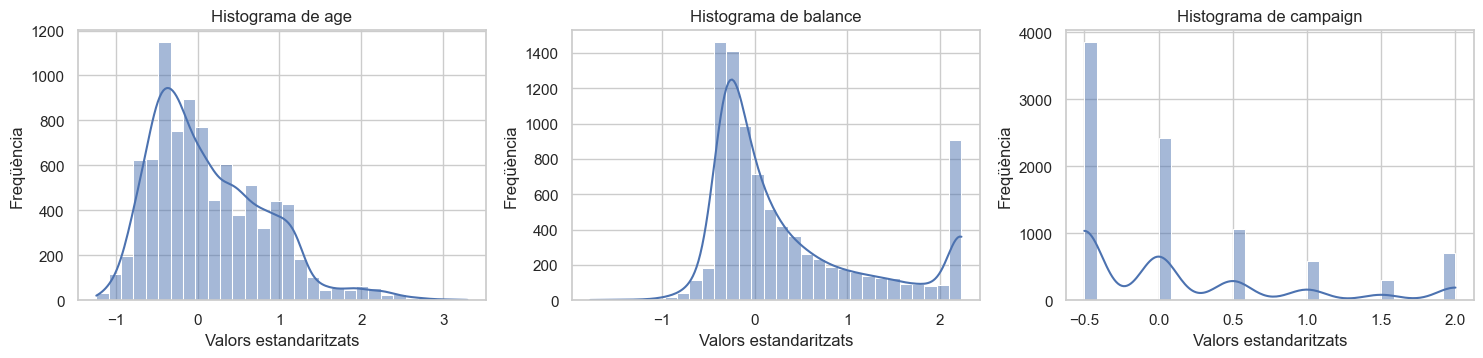

In [108]:
# Selecciona les variables estandaritzades en train5
variables_estandarizadas = train6[['age', 'balance', 'campaign',]]

# Configurar la mida i estil
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Crear histogrames per a cada variable
for i, column in enumerate(variables_estandarizadas.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(variables_estandarizadas[column], bins=30, kde=True)
    plt.title(f'Histograma de {column}')
    plt.xlabel('Valors estandaritzats')
    plt.ylabel('Freqüència')

plt.tight_layout()
plt.show()

In [109]:
# Verificar estandarització.
test6.describe()

,age,balance,campaign,education_encoded,month_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000
mean,0.123126,0.389508,0.124272,2.103448,5.188983,2.173757,0.130766,0.464845,0.120466,0.566055,0.313032,0.000448
std,0.696858,0.872705,0.755732,0.790599,2.574886,0.650538,0.337220,0.498874,0.325578,0.495729,0.463831,0.021162
min,-1.235294,-1.792199,-0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.411765,-0.268542,-0.500000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.058824,0.008951,0.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.588235,0.797954,0.500000,3.000000,7.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,2.823529,2.264066,2.000000,3.000000,11.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


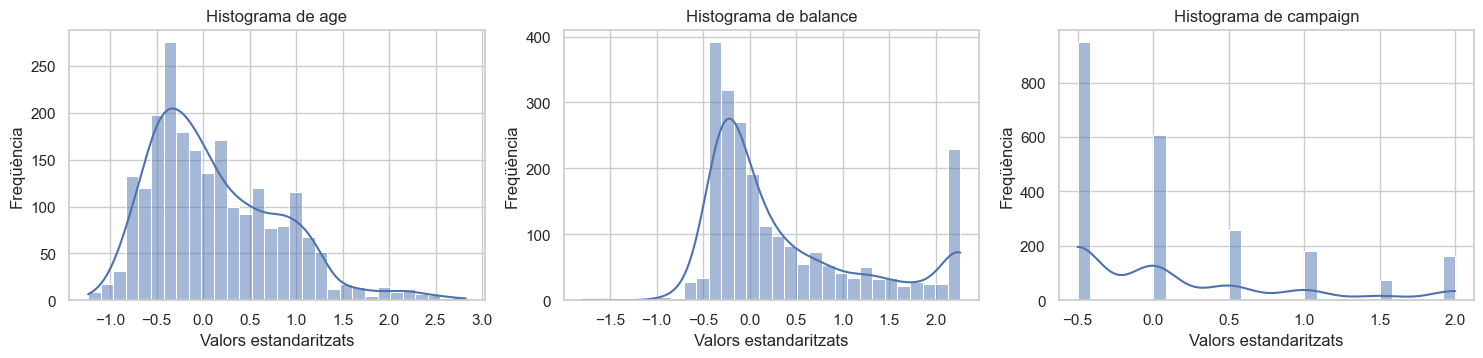

In [110]:
# Selecciona les variables estandaritzadas en test5
variables_estandarizadas = test6[['age', 'balance', 'campaign',]]

# Configurar la mida i estil
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Crear histogrames per a cada variable
for i, column in enumerate(variables_estandarizadas.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(variables_estandarizadas[column], bins=30, kde=True)
    plt.title(f'Histograma de {column}')
    plt.xlabel('Valors estandaritzats')
    plt.ylabel('Freqüència')

plt.tight_layout()
plt.show()

****

### 6. Entrenar els models

In [111]:
train7 = train6
test7 = test6

****
### 6.1. Entrenament i Avaluació del Model K-means

- Seleccionar el nombre optim de Clusters 𝑘 per K-means.

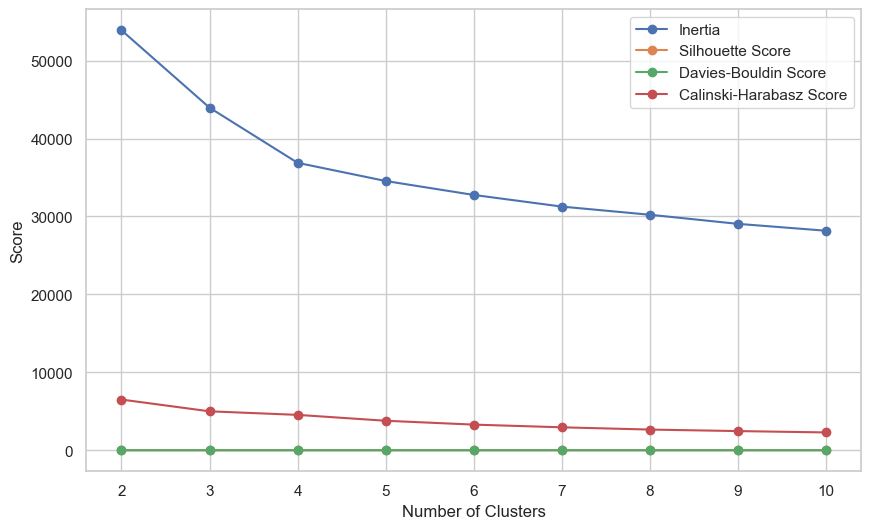

In [112]:
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(train7)
    cluster_labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(train7, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(train7, cluster_labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(train7, cluster_labels))

# Plot results to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', label='Inertia')
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.plot(cluster_range, davies_bouldin_scores, marker='o', label='Davies-Bouldin Score')
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

In [113]:
## Fem una comprovació per veure quin seria el numero de clusters més adient:
results = []
for k in range(2, 10):  # Comprovació amb valors de 2 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(train7.drop(columns='cluster', errors='ignore'))
    
    inercia = kmeans.inertia_
    silhouette = silhouette_score(train7.drop(columns='cluster', errors='ignore'), clusters)
    davies_bouldin = davies_bouldin_score(train7.drop(columns='cluster', errors='ignore'), clusters)
    calinski_harabasz = calinski_harabasz_score(train7.drop(columns='cluster', errors='ignore'), clusters)
    
    results.append((k, inercia, silhouette, davies_bouldin, calinski_harabasz))

# Mostrar els resultats
for k, inercia, silhouette, davies_bouldin, calinski_harabasz in results:
    print(f"k={k}: Inercia={inercia:.2f}, Silueta={silhouette:.3f}, Davies-Bouldin={davies_bouldin:.3f}, Calinski-Harabasz={calinski_harabasz:.2f}")

k=2: Inercia=53901.02, Silueta=0.338, Davies-Bouldin=1.117, Calinski-Harabasz=6505.83
k=3: Inercia=44965.45, Silueta=0.261, Davies-Bouldin=1.174, Calinski-Harabasz=4785.79
k=4: Inercia=36896.71, Silueta=0.250, Davies-Bouldin=1.399, Calinski-Harabasz=4538.43
k=5: Inercia=35106.17, Silueta=0.217, Davies-Bouldin=1.602, Calinski-Harabasz=3690.79
k=6: Inercia=34325.18, Silueta=0.198, Davies-Bouldin=1.832, Calinski-Harabasz=3060.09
k=7: Inercia=32727.42, Silueta=0.192, Davies-Bouldin=1.856, Calinski-Harabasz=2746.86
k=8: Inercia=30262.32, Silueta=0.171, Davies-Bouldin=1.886, Calinski-Harabasz=2649.76
k=9: Inercia=29332.00, Silueta=0.168, Davies-Bouldin=1.847, Calinski-Harabasz=2427.18


In [114]:
# Entrenar el model K-means:
k = 2  # Es decideix que el més adient es aquest

# Crear y ajustar el model K-means
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(train7) 
clusters = kmeans.predict(train7)
kmeans.fit(test7) 
clusters_test = kmeans.predict(test7)

# Asignar els clusters al DataFrame
train8 = train7.copy()  # Crear una copia per evitar errors de referencia
train8['cluster'] = clusters
test8 = test7.copy()  # Crear una copia per evitar errors de referencia
test8['cluster'] = clusters_test

- Escollim el numero de clusters que tingui el nivell més baix de l'índex de Davies-Bouldini, el més alt de Calinski_Harbasz i el més estable possible en baixada d'inercia.

In [115]:
# Calcular mètriques per a K-means
# Inèrcia (Suma de Quadrats de Distàncies Internes)
inercia = kmeans.inertia_
print("Inèrcia:", inercia)

# Coeficient de Silueta
silhouette = silhouette_score(train8.drop(columns='cluster'), clusters)
print("Índex de Silueta:", silhouette)

# Índex de Davies-Bouldin
davies_bouldin = davies_bouldin_score(train8.drop(columns='cluster'), clusters)
print("Índex de Davies-Bouldin:", davies_bouldin)

# Índex de Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(train8.drop(columns='cluster'), clusters)
print("Índex de Calinski-Harabasz:", calinski_harabasz)

Inèrcia: 13556.678156776652
Índex de Silueta: 0.3380045203823883
Índex de Davies-Bouldin: 1.1170093830612324
Índex de Calinski-Harabasz: 6505.829740432902


In [116]:
# Redimensionar para mejorar el índice de silueta
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(train8)

kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(X_pca)

silhouette_avg = silhouette_score(X_pca, labels)
print("Índice de Silueta después de PCA:", silhouette_avg)

Índice de Silueta después de PCA: 0.5178805213032407


In [117]:
print("Columnes de train8:", train8.columns)
print("Columnes de test8:", test8.columns)

Columnes de train8: Index(['age', 'balance', 'campaign', 'education_encoded', 'month_encoded',
       'job_grouped_encoded', 'loan', 'housing', 'marital_divorced',
       'marital_married', 'marital_single', 'marital_unknown', 'cluster'],
      dtype='object')
Columnes de test8: Index(['age', 'balance', 'campaign', 'education_encoded', 'month_encoded',
       'job_grouped_encoded', 'loan', 'housing', 'marital_divorced',
       'marital_married', 'marital_single', 'marital_unknown', 'cluster'],
      dtype='object')


In [118]:
print(kmeans.cluster_centers_)

[[-1.86594378  0.01301939]
 [ 2.46947438 -0.01723045]]


****
### 6.2. Entrenament i Avaluació del Model de Regressió Logística

In [119]:
# variable objectiu
y = y_train['deposit']
yy = y_test['deposit']
print(y.shape)
print(yy.shape)

(8929,)
(2233,)


In [120]:
# Entrenar el model de Regressió Logística
# Crear i ajustar el model
model = LogisticRegression(random_state=0)
model.fit(train8, y)

# Predecir en el conjunto de prueba
y_pred = model.predict(test8)
y_proba = model.predict_proba(test8)[:, 1]  # Probabilidades para calcular ROC y Log-Loss

In [133]:
# Calcular les mètriques per a la Regressió Logística
# Curva ROC y AUC
auc = roc_auc_score(yy, y_proba)
print("AUC:", auc)

fpr, tpr, _ = roc_curve(yy, y_proba)

# Exactitud (Accuracy)
accuracy = accuracy_score(yy, y_pred)
print("Exactitud (Accuracy):", accuracy)

# Precisió (Precision)
precision = precision_score(yy, y_pred)
print("Precisión (Precision):", precision)

# Recall (Sensibilidad)
recall = recall_score(yy, y_pred)
print("Recall:", recall)

# F1 Score
f1 = f1_score(yy, y_pred)
print("F1 Score:", f1)

# Matriu de Confusió
confusion = confusion_matrix(yy, y_pred)
print("Matriz de Confusión:\n", confusion)

# Log-Loss
logloss = log_loss(yy, y_proba)
print("Log-Loss:", logloss)

AUC: 0.6768579817399349
Exactitud (Accuracy): 0.6332288401253918
Precisión (Precision): 0.6152362584378014
Recall: 0.6030245746691871
F1 Score: 0.6090692124105012
Matriz de Confusión:
 [[776 399]
 [420 638]]
Log-Loss: 0.646533893237837


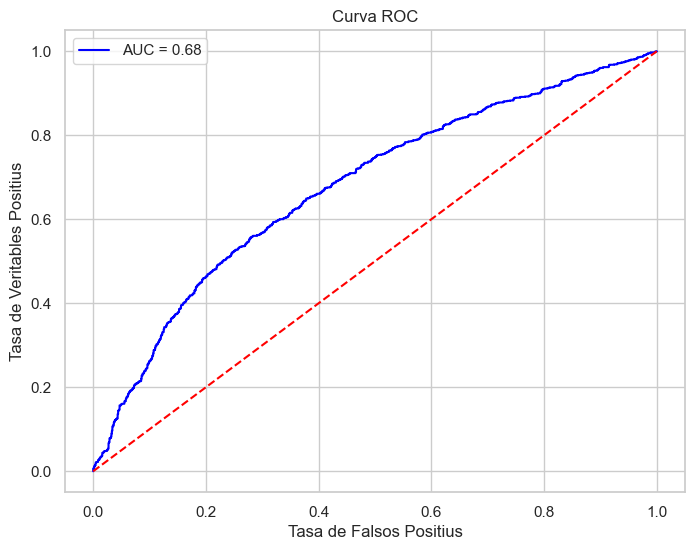

In [134]:
# Visualització
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Tasa de Falsos Positius')
plt.ylabel('Tasa de Veritables Positius')
plt.title('Curva ROC')
plt.legend()
plt.show()

****
### 7. Guardar el model i l'escalador

In [135]:
# Guardar les columnes
with open('features.pkl', 'wb') as features_file:
    pickle.dump(list(train8.columns), features_file)

# Guardar els models
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('kmeans_model.pkl', 'rb') as f:
    kmeans = pickle.load(f)

with open('logistic_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Guardar l'escalador
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

****
### 8. Resultats dels models

In [136]:
# Afegir l'assignació de cluster al DataFrame original
train8['cluster'] = kmeans.labels_

In [137]:
# Estadístiques descriptives per cluster
cluster_summary = train8.groupby('cluster').mean()
print(cluster_summary)

              age   balance  campaign  education_encoded  month_encoded  \
cluster                                                                   
0        0.074831  0.326507  0.049351           2.069210       3.374558   
1        0.211309  0.394920  0.208951           2.155087       7.595628   

         job_grouped_encoded      loan   housing  marital_divorced  \
cluster                                                              
0                   2.199961  0.120134  0.584546          0.111089   
1                   2.182930  0.144939  0.330471          0.118918   

         marital_married  marital_single  marital_unknown  
cluster                                                    
0               0.547582        0.341329         0.000000  
1               0.598491        0.281551         0.001041  


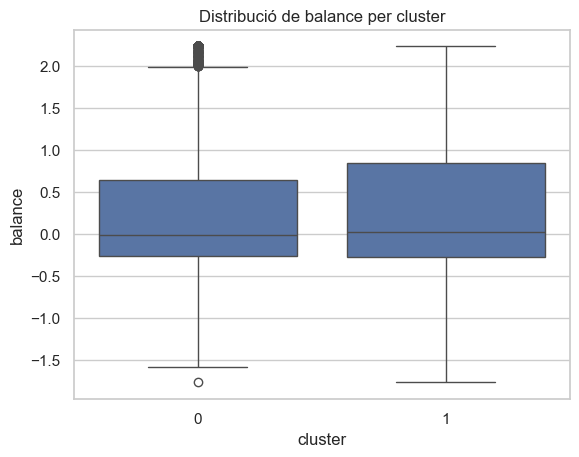

In [149]:
# Distribución d 'balance' per cluster
sns.boxplot(data=train8, x='cluster', y='balance')
plt.title("Distribució de balance per cluster")
plt.show()

In [139]:
# Combinar train8 y y
train_combined = pd.concat([train8, y], axis=1)

# Tasa de conversió per cluster
conversion_rate = train_combined.groupby('cluster')['deposit'].mean()
print(conversion_rate)

cluster
0.0    0.587844
1.0    0.600979
Name: deposit, dtype: float64


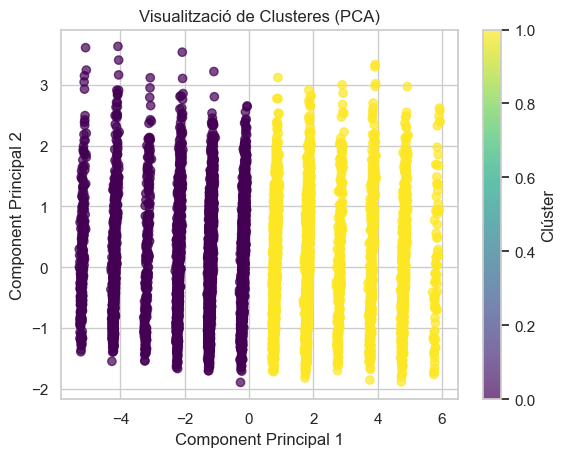

In [140]:
# Reduir a 2 dimensions par a graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train8.drop(columns='cluster'))

# Graficar
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train8['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Clúster')
plt.title("Visualització de Clusteres (PCA)")
plt.xlabel("Component Principal 1")
plt.ylabel("Component Principal 2")
plt.show()

- Gràfic de taxes de conversió per clúster: Per identificar els clústers amb més taxes de conversió i prioritzar esforços de màrqueting en aquests segments.

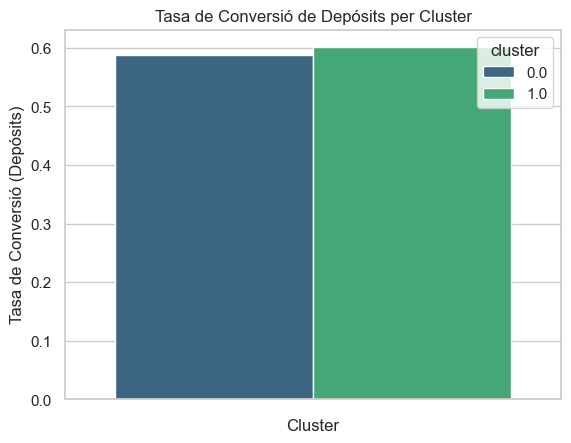

In [141]:
# Combinar train i y temporalmente
train_combined = pd.concat([train8, y], axis=1)

# Calcular tases de conversió per clúster
cluster_conversion = train_combined.groupby('cluster')['deposit'].mean()
# Visualizar
sns.barplot(hue=cluster_conversion.index, y=cluster_conversion.values, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Tasa de Conversió (Depósits)")
plt.title("Tasa de Conversió de Depósits per Cluster")
plt.show()

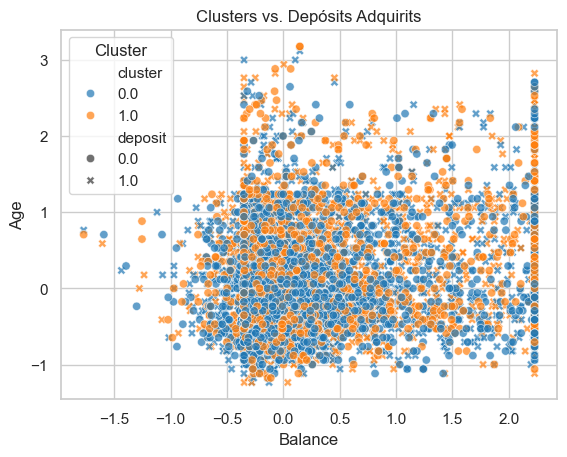

In [142]:
# Agregar la variable objetiu al conjunt train
train_combined = pd.concat([train8, y], axis=1)

# Scatterplot
sns.scatterplot(
    x='balance', y='age', 
    hue='cluster', style=train_combined['deposit'], 
    data=train_combined, palette="tab10", alpha=0.7
)
plt.xlabel("Balance")
plt.ylabel("Age")
plt.title("Clusters vs. Depósits Adquirits")
plt.legend(title="Cluster")
plt.show()

- Gràfic de barres acumulat per clúster i mes: Per etectar patrons estacionals per planificar campanyes publicitàries o promocions.

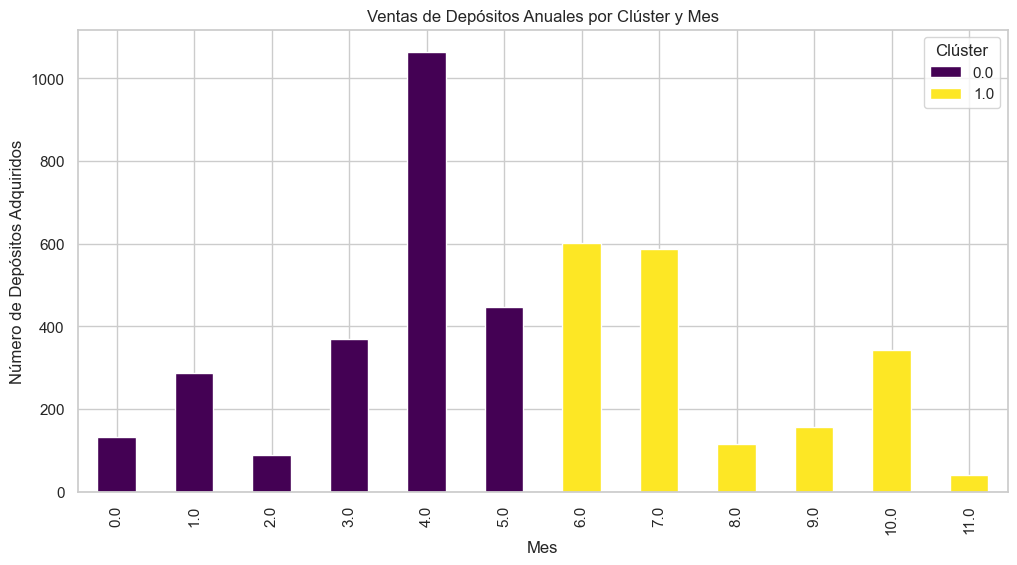

In [143]:
# Combinar X_train y y_train temporalmente
train_combined = pd.concat([train8, y], axis=1)

# Agrupar por mes y cluster
monthly_sales = train_combined[train_combined['deposit'] == 1].groupby(['month_encoded', 'cluster']).size().unstack(fill_value=0)

# Visualizar
monthly_sales.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.xlabel("Mes")
plt.ylabel("Número de Depósitos Adquiridos")
plt.title("Ventas de Depósitos Anuales por Clúster y Mes")
plt.legend(title="Clúster")
plt.show()

- Gràfic de línies: Per poder preveure vendes futures sobre la base de tendències històriques i ajustar objectius anuals.

month_encoded
0.0      133
1.0      288
2.0       89
3.0      368
4.0     1065
5.0      446
6.0      601
7.0      586
8.0      115
9.0      156
10.0     343
11.0      41
dtype: int64


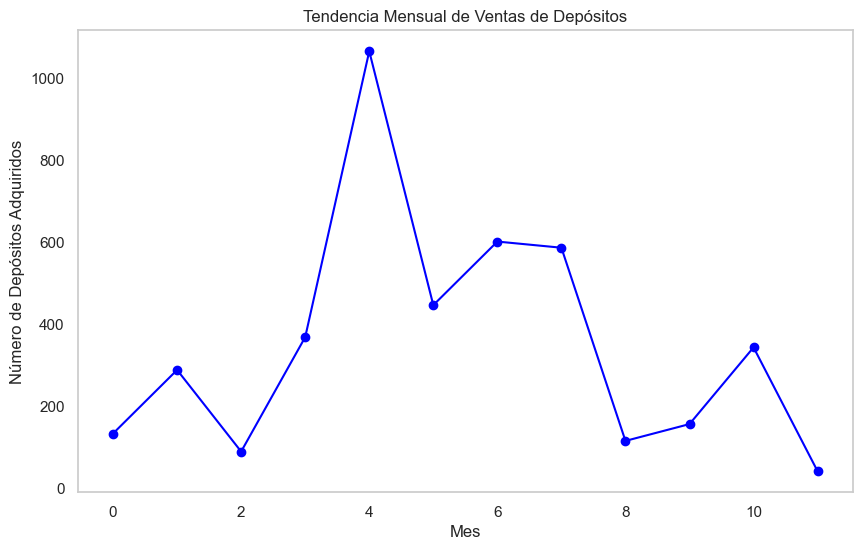

In [144]:
# Combinar X_train y y_train temporalmente
train_combined = pd.concat([train8, y_train], axis=1)

# Agrupar por mes y verificar
monthly_trend = train_combined[train_combined['deposit'] == 1].groupby('month_encoded').size()
print(monthly_trend)  # Revisa si hay datos en cada mes

# Visualizar la tendencia
monthly_trend.plot(kind='line', marker='o', figsize=(10, 6), color='blue')
plt.xlabel("Mes")
plt.ylabel("Número de Depósitos Adquiridos")
plt.title("Tendencia Mensual de Ventas de Depósitos")
plt.grid()
plt.show()

In [151]:
# Obtenir els coeficients i l'intercepte
coef = model.coef_[0]
intercept = model.intercept_[0]

# Mostrar els coeficients asociats a cada característique
for feature, coef_value in zip(X.columns, coef):
    print(f"Feature: {feature}, Coefficient: {coef_value}")

print(f"Intercept: {intercept}")

Feature: age, Coefficient: 0.16523657835895159
Feature: job, Coefficient: 0.24395866679788483
Feature: marital, Coefficient: -0.38695245173061193
Feature: education, Coefficient: 0.15245220098995313
Feature: balance, Coefficient: -0.02163040861489308
Feature: housing, Coefficient: 0.1441032315826565
Feature: loan, Coefficient: -0.4275734239195695
Feature: month, Coefficient: -0.6893154228294773
Feature: campaign, Coefficient: -0.12591968496241343
Intercept: -0.27231175920114853


****
### 9. Conclusions finals

**Resultats dels coeficinets:**
- Un coeficient positiu implica que un augment en aquesta característica augmenta la probabilitat que el client faci un dipòsit (classe 1). Com és el cas de: age, job, education i housing.
- Un coeficient negatiu indica que un augment en aquesta característica en disminueix la probabilitat. Com és el cas de marital, balance, loan, month and campaign.
- Com més gran sigui el valor absolut del coeficient, més gran és l'impacte d'aquesta característica en el resultat.

**Resultats del K-means (Clustering)**

- Nombre de clústers: 2
- Inèrcia (13556.68): suggereix que els punts dins de cada clúster estan relativament a prop dels seus centroides, cosa que és bona per a una segmentació compacta.
- Índex de Silueta (0.5179): els clústers estan ben separats i tenen una cohesió raonable.
- Índex de Davies-Bouldin (1.1170): Com més proper a 0, millor. Aquest valor indica que els clústers tenen bones separacions i mides.
- Índex de Calinski-Harabasz (6505.83): Un valor alt suggereix una bona densitat de clústers i una bona separació entre ells com és el cas raonablement.

**Resultats del Model de Regressió Logística**

- AUC (0.6769): Mostra una capacitat moderada del model per distingir entre classes (clients que dipositen davant dels que no). Tot i que no és excel·lent, està per sobre de l'atzar (0,5).
- Exactitud (Accuracy) (63.32%): Mostra el percentatge de prediccions correctes del model. Aquest valor és acceptable, però hi ha marge per a millora.
- Precisió (61.52%): El model identifica correctament els clients que realment dipositen el 61.52% de les vegades.
- Recall (60,30%): El model captura el 60,30% dels clients que efectivament dipositen.
- F1 Score (0.6091): Equilibra precisió i recall. El valor indica un model moderadament balancejat.
- Matriu de Confusió:[[776 399] # Veritables Negatius, Falsos Positius [420 638]] # Falsos Negatius, Veritables Positius.
    Falsos positius (399): Clients que el model prediu que dipositaran però no ho fan.
    Falsos negatius (420): Clients que el model no va predir com a possibles dipositants però sí que ho són.
- Log-Loss (0.6465): Aquest valor indica què tan malament estan calibrades les probabilitats del model. Un valor baix suggereix que les prediccions probabilístiques són raonablement fiables, sent en aquest cas acceptables, però millorables.

**Descripció dels clusters:** 
- *Clúster 0 (Clients amb alta conversió)* Major edat (45 anys o més). Saldos bancaris alts. Menys probabilitat de tenir préstecs.
- Recomanacions:
- Oferir dipòsits exclusius: Dissenyar productes amb taxes d'interès atractives i beneficis addicionals (eg, dipòsits a llarg termini amb bonificacions).
- Màrqueting personalitzat: Enviar missatges personalitzats destacant els beneficis del dipòsit, com a seguretat i retorn a llarg termini.
- Assessors dedicats: Oferir assessorament personalitzat per ajudar aquests clients a planificar els seus estalvis.
- *Clúster 1 (Clients amb baixa conversió)* Més joves (menors de 35 anys). Saldos més baixos. Major dependència de préstecs.
- Recomanacions:
- Dipòsits flexibles: Dissenyar productes accessibles amb munts mínims baixos i opcions de retir flexible per atraure aquests clients.
- Educació financera: Implementar campanyes que expliquin la importància d'estalviar i els avantatges dels dipòsits davant de l'ús de préstecs.
- Ofertes creuades: Relacionar dipòsits amb altres productes com ara comptes d'estalvi o targetes de crèdit amb taxes preferencials.

**Resum d'estratègia de Màrqueting:**
- Anàlisi de clients no convertits: Investigar quins factors impedeixen que els clients dipositin i enfocar els esforços a resoldre aquestes barreres.
- Reforçar amb nous canals de comunicació: Analitzar si els clients podrien preferir interactuar per altres canals que no sigui el telefònic com podria ser en persona, per correu electronic o a través d'un lloc web o una aplicació mòbil, i millorar l'experiència al canal.
- Optimització de campanyes: Fer servir un model predictiu per identificar clients amb alta probabilitat de conversió dins de cada clúster i enfocar els recursos de màrqueting en ells.

****